In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision import transforms


In [2]:
import matplotlib.pyplot as plt

# Dataset - Fashion MNIST

In [3]:
train_data=datasets.FashionMNIST(
    root="data",#where to download the data to
    train=True,#do we want training dataset
    download=True,#do we want to download it?
    transform=transforms.ToTensor(),
    target_transform=None #do we want to transform the target?
)
test_data=datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [4]:
len(train_data),len(test_data)

(60000, 10000)

In [5]:
image,label=train_data[0]
label

9

In [6]:
class_names=train_data.classes

In [7]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
class_idx=train_data.class_to_idx
class_idx#dict

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

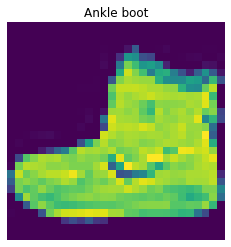

In [9]:
plt.imshow(image.squeeze())
plt.title(class_names[label])
plt.axis(False)
plt.show()

Randomly visualise images from dataset

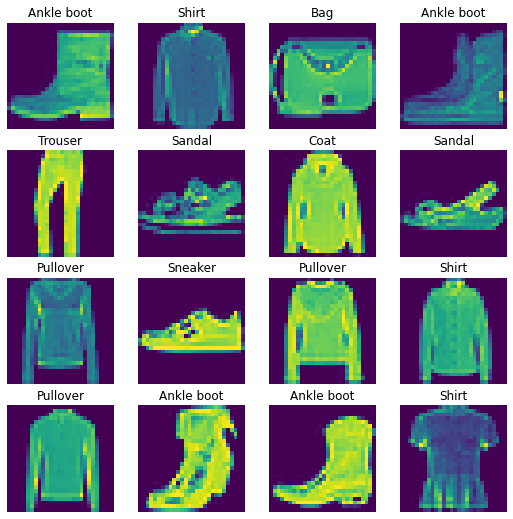

In [10]:
torch.manual_seed(42)
plt.figure(figsize=(9,9))
rows,cols=4,4
for i in range(1,rows*cols+1):
  random_idx=torch.randint(0,len(train_data),size=[1]).item()#return a random integer between 0 and 60,000
  img,label=train_data[random_idx]
  plt.subplot(rows,cols,i)
  plt.imshow(img.squeeze())
  plt.title(class_names[label])
  plt.axis(False)


#Using DataLoaders

In [11]:
train_data,test_data

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(), Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [12]:
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader=DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader=DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False)
print(f"Number of training batches : {len(train_dataloader)}, each of size {BATCH_SIZE}")
print(f"Number of testing batches : {len(test_dataloader)}, each of size {BATCH_SIZE}")

Number of training batches : 1875, each of size 32
Number of testing batches : 313, each of size 32


In [13]:
train_features_batch,train_labels_batch=next(iter(train_dataloader))
train_features_batch.shape,train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

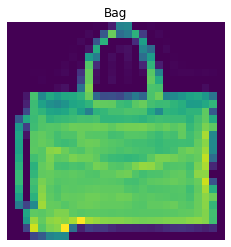

In [14]:
# torch.manual_seed(42)
random_idx=torch.randint(0,len(train_features_batch),size=[1]).item()
img,label=train_features_batch[random_idx],train_labels_batch[random_idx]
plt.imshow(img.squeeze())
plt.title(class_names[label])
plt.axis(False)
plt.show()

#Construct a model

In [15]:
train_features_batch[0].shape

torch.Size([1, 28, 28])

In [16]:
flatten_layer=nn.Flatten()
flatten_layer(train_features_batch[0]).shape


torch.Size([1, 784])

In [17]:
class FashionMNISTModelV0(nn.Module):
  def __init__(self,input_shape,hidden_units,output_shape):
    super().__init__()
    self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape,hidden_units),
        nn.Linear(hidden_units,output_shape)
    )
  def forward(self,x):
    return self.layer_stack(x)

In [18]:
torch.manual_seed(42)
model_0=FashionMNISTModelV0(input_shape=784,hidden_units=10,output_shape=10)
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [19]:
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [20]:
dummy_x=torch.rand([1,1,28,28])
model_0(dummy_x)

tensor([[-0.0315,  0.3171,  0.0531, -0.2525,  0.5959,  0.2112,  0.3233,  0.2694,
         -0.1004,  0.0157]], grad_fn=<AddmmBackward0>)

# setup loss, optimizers and loss functions

In [21]:
import requests
from pathlib import Path

response=requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
#skip download if file already exists
if Path("helper_functions.py").is_file():
  pass
else:
  with open("helper_functions.py","wb") as f:
    f.write(response.content)
from helper_functions import accuracy_fn

In [22]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model_0.parameters(),lr=0.1)

#time our experiments

In [23]:
from timeit import default_timer as timer
def print_train_time(start,end,device=None):
  """Prints diff between start and end time"""
  total_time=end-start
  print(f"Train time on device : {device} = {total_time:.3f}")
  return total_time


# Training loop:
1. Loop through epochs
2. Loop through training batches, perform training steps, calculate training loss **per batch**
3. Loop through testing batches, perform testing steps, calculate testing loss **per batch**
4. Print out status
5. Time it all

In [24]:
for batch , (X,y) in enumerate(train_dataloader):
  print(model_0(X).shape)
  print(y.shape)
  break

torch.Size([32, 10])
torch.Size([32])


In [25]:
#tqdm for progress bar
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_cpu=timer()
#start with small number of epochs
epochs=3
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n------")
  #Training
  train_loss=0 #allows us to visualise the accumulation of training loss and also allows calculation of average loss over all the batches
  #loop through training batches
  for batch,(X,y) in enumerate(train_dataloader):
    model_0.train()
    y_pred=model_0(X)
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(train_dataloader)
  #testing loop
  test_loss,test_acc=0,0
  model_0.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      test_pred=model_0(X_test)
      test_loss+=loss_fn(test_pred,y_test)#loss fn takes in logits
      test_acc+=accuracy_fn(y_test,test_pred.argmax(dim=1))
    #calculate average loss and accuracy over all the batched data
    test_loss/=len(test_dataloader)
    test_acc/=len(test_dataloader)
  print(f"Train loss : {train_loss}, test loss : {test_loss}, test accuracy : {test_acc}")
  

train_time_end_on_cpu=timer()
print_train_time(train_time_start_on_cpu,train_time_end_on_cpu,str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
------
Train loss : 0.5903892517089844, test loss : 0.5095350742340088, test accuracy : 82.03873801916933
Epoch : 1
------
Train loss : 0.4763319790363312, test loss : 0.47988998889923096, test accuracy : 83.19688498402556
Epoch : 2
------
Train loss : 0.4550333023071289, test loss : 0.47663894295692444, test accuracy : 83.42651757188499
Train time on device : cpu = 41.706


41.706234843999994

In [26]:
str(next(model_0.parameters()).device)

'cpu'

# Make predicitions and evaluate model_0

In [27]:
type(loss_fn)

torch.nn.modules.loss.CrossEntropyLoss

In [28]:
torch.manual_seed(42)
def evaluate_model(model:torch.nn.Module,data_loader:torch.utils.data.DataLoader,loss_fn:torch.nn.modules,accuracy_fn):
  """Returns a dictionary containing the results of model predicting on data_loader."""
  loss,acc=0,0
  model.eval()
  with torch.inference_mode():
    for X,y in data_loader:
      y_pred=model(X)
      loss+=loss_fn(y_pred,y)
      acc+=accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))

    loss/=len(data_loader)
    acc/=len(data_loader)
  return {"model_name":model.__class__.__name__,"model_loss":loss.item(),"accuracy":acc}

evaluate_model(model=model_0,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn)

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'accuracy': 83.42651757188499}

In [29]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Building a model with non-linearity

In [30]:
class FashionMNISTModelV1(nn.Module):
  def __init__(self,input_shape,hidden_units,output_shape):
    super().__init__()
    self.layer_stack=nn.Sequential(
        nn.Flatten(),
        nn.Linear(input_shape,hidden_units),
        nn.ReLU(),
        nn.Softmax(),
        nn.Linear(hidden_units,output_shape)
    )

  def forward(self,x):
    return self.layer_stack(x)
model_1=FashionMNISTModelV1(784,64,10).to(device)

In [31]:
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [32]:
#tqdm for progress bar
from tqdm.auto import tqdm
torch.manual_seed(42)
train_time_start_on_gpu=timer()
#start with small number of epochs
epochs=3
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n------")
  #Training
  train_loss=0 #allows us to visualise the accumulation of training loss and also allows calculation of average loss over all the batches
  #loop through training batches
  for batch,(X,y) in enumerate(train_dataloader):
    X,y=X.to(device),y.to(device)
    model_1.train()
    y_pred=model_1(X)
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(train_dataloader)
  #testing loop
  test_loss,test_acc=0,0
  model_1.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      X_test,y_test=X_test.to(device),y_test.to(device)
      test_pred=model_1(X_test)
      test_loss+=loss_fn(test_pred,y_test)#loss fn takes in logits
      test_acc+=accuracy_fn(y_test,test_pred.argmax(dim=1))
    #calculate average loss and accuracy over all the batched data
    test_loss/=len(test_dataloader)
    test_acc/=len(test_dataloader)
  print(f"Train loss : {train_loss}, test loss : {test_loss}, test accuracy : {test_acc}")
  

train_time_end_on_gpu=timer()
print_train_time(train_time_start_on_gpu,train_time_end_on_gpu,str(next(model_1.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
------


/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train loss : 1.8699302673339844, test loss : 1.6875226497650146, test accuracy : 24.6305910543131
Epoch : 1
------
Train loss : 1.624190330505371, test loss : 1.5668495893478394, test accuracy : 31.749201277955272
Epoch : 2
------
Train loss : 1.500862956047058, test loss : 1.4230107069015503, test accuracy : 39.00758785942492
Train time on device : cuda:0 = 38.090


38.09018219400002

###Refactor the training code and testing code

In [33]:
def train_step(model,train_dataloader,loss_fn,optimizer,device,accuracy_fn):
  torch.manual_seed(42)
  train_time_start_on_gpu=timer()
  
  #Training
  model.train()
  train_loss,train_acc=0,0 #allows us to visualise the accumulation of training loss and also allows calculation of average loss over all the batches
  #loop through training batches
  for batch,(X,y) in enumerate(train_dataloader):
    X,y=X.to(device),y.to(device)
    model.train()
    y_pred=model(X)
    loss=loss_fn(y_pred,y)
    train_loss+=loss
    train_acc+=accuracy_fn(y_true=y,y_pred=y_pred.argmax(dim=1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss/=len(train_dataloader)
  train_acc/=len(train_dataloader)
  print(f"Train loss:{train_loss}, Train accuracy : {train_acc}")
  train_time_end_on_gpu=timer()


In [34]:
def test_step(model,test_dataloader,loss_fn,device,accuracy_fn):
  test_loss,test_acc=0,0
  model.eval()
  with torch.inference_mode():
    for X_test,y_test in test_dataloader:
      X_test,y_test=X_test.to(device),y_test.to(device)
      test_pred=model(X_test)
      test_loss+=loss_fn(test_pred,y_test)#loss fn takes in logits
      test_acc+=accuracy_fn(y_test,test_pred.argmax(dim=1))
    #calculate average loss and accuracy over all the batched data
    test_loss/=len(test_dataloader)
    test_acc/=len(test_dataloader)
  print(f"test loss : {test_loss}, test accuracy : {test_acc}")



In [35]:
model_1=FashionMNISTModelV1(784,64,10).to(device)

In [36]:
optimizer=torch.optim.SGD(params=model_1.parameters(),lr=0.1)

In [37]:
device

'cuda'

In [38]:
train_step(model_1,train_dataloader,loss_fn,optimizer,device,accuracy_fn)

Train loss:1.831795334815979, Train accuracy : 29.321666666666665


In [39]:
test_step(model_1,test_dataloader,loss_fn,device,accuracy_fn)

test loss : 1.4835891723632812, test accuracy : 44.27915335463259


Create an optimization and evaluation loop using the train_step and test_step functions

In [40]:
torch.manual_seed(42)
from timeit import default_timer as timer
train_time_start_gpu=timer()
epochs=3

for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}\n")
  train_step(model=model_1,train_dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,device=device,accuracy_fn=accuracy_fn)
  test_step(model=model_1,test_dataloader=test_dataloader,loss_fn=loss_fn,device=device,accuracy_fn=accuracy_fn)


train_time_end_gpu=timer()
print(f"Training time on GPU : {train_time_end_gpu-train_time_start_gpu}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0

Train loss:1.3274074792861938, Train accuracy : 45.89
test loss : 1.2426472902297974, test accuracy : 48.79193290734824
Epoch : 1

Train loss:1.2063201665878296, Train accuracy : 49.635
test loss : 1.249268651008606, test accuracy : 53.29472843450479
Epoch : 2

Train loss:1.169924259185791, Train accuracy : 51.10666666666667
test loss : 1.3333216905593872, test accuracy : 49.67052715654952
Training time on GPU : 36.000313183


In [41]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device=device):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    loss, acc = 0, 0
    model=model.to(device)
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X,y=X.to(device),y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663894295692444,
 'model_acc': 83.42651757188499}

In [42]:
model_0

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

CNNs

Implementing the TinyVGG architecture

In [43]:
class FashionMNISTModelV2(nn.Module):
  def __init__(self,in_channels:int,hidden_units:int,output_shape:int):
   
    super().__init__()
    self.conv_block_1=nn.Sequential(
        nn.Conv2d(in_channels=in_channels,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )
    self.conv_block_2=nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,out_channels=hidden_units,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,out_channels=output_shape,kernel_size=3,padding=1,stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier_layer=nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7,out_features=output_shape)
    )

  def forward(self,x):
    # return self.classifier_layer(self.conv_block_2(self.conv_block_1(x)))
    x=self.conv_block_1(x)
    # print(f"Output shape of conv_block_1 : {x.shape}")
    x=self.conv_block_2(x)
    # print(f"Output shape of conv_block_2 : {x.shape}")
    x=self.classifier_layer(x)
    # print(f"Output shape of classifier layer : {x.shape}")
    return x



In [44]:
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [45]:
torch.manual_seed(42)
model_2=FashionMNISTModelV2(in_channels=1,hidden_units=10,output_shape=len(class_names)).to(device)


In [46]:
rand_image_tensor=torch.randn(size=(1,28,28))

In [47]:
rand_image_tensor.shape

torch.Size([1, 28, 28])

In [48]:
#pass image through the model
model_2(rand_image_tensor.unsqueeze(0).to(device))

tensor([[ 0.0366, -0.0940,  0.0686, -0.0485,  0.0068,  0.0290,  0.0132,  0.0084,
         -0.0030, -0.0185]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [49]:
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(params=model_2.parameters(),lr=0.1)

In [50]:
train_time_start_model_2=timer()

epochs=3
for epoch in tqdm(range(epochs)):
  print(f"Epoch : {epoch}")
  train_step(model=model_2,train_dataloader=train_dataloader,loss_fn=loss_fn,optimizer=optimizer,device=device,accuracy_fn=accuracy_fn)
  test_step(model=model_2,test_dataloader=test_dataloader,loss_fn=loss_fn,device=device,accuracy_fn=accuracy_fn)

train_time_end_model_2=timer()
print("Time taken to train and test model_2 : ",train_time_end_model_2-train_time_start_model_2)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch : 0
Train loss:0.5903325080871582, Train accuracy : 78.63333333333334
test loss : 0.3987269401550293, test accuracy : 85.8526357827476
Epoch : 1
Train loss:0.3635566532611847, Train accuracy : 87.025
test loss : 0.36325982213020325, test accuracy : 86.78115015974441
Epoch : 2
Train loss:0.32666444778442383, Train accuracy : 88.22
test loss : 0.3600832223892212, test accuracy : 87.25039936102236
Time taken to train and test model_2 :  44.87054782599995


In [51]:
model_2_results=eval_model(model=model_2, 
               data_loader=test_dataloader, 
               loss_fn=loss_fn, 
               accuracy_fn=accuracy_fn,
               device=device)
print(model_2_results)

{'model_name': 'FashionMNISTModelV2', 'model_loss': 0.3600832223892212, 'model_acc': 87.25039936102236}


In [52]:
model_1_results=eval_model(model=model_1,data_loader=test_dataloader,loss_fn=loss_fn,accuracy_fn=accuracy_fn,device=device)

In [53]:
#Compare model results
import pandas as pd
model_results=pd.DataFrame([model_0_results,model_1_results,model_2_results])


In [54]:
print(model_results)

            model_name  model_loss  model_acc
0  FashionMNISTModelV0    0.476639  83.426518
1  FashionMNISTModelV1    1.333322  49.670527
2  FashionMNISTModelV2    0.360083  87.250399


<AxesSubplot:ylabel='model_name'>

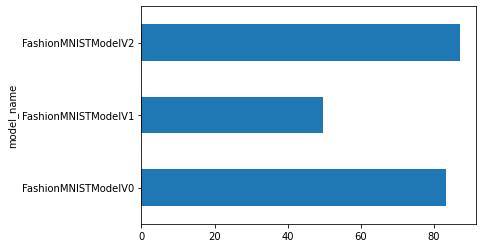

In [55]:
model_results.set_index('model_name')['model_acc'].plot(kind='barh')

Make and evaluate random predictions with our best model

In [56]:
def get_preds(model:torch.nn.Module,data:list,device:torch.device=device):
  pred_probs=[]
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample=torch.unsqueeze(sample,dim=0).to(device)#add a batch dimension in the beginning, pass to device
      logits=model(sample)
      pred_prob=torch.softmax(logits.squeeze(),dim=0)
      pred_probs.append(pred_prob.cpu())
  return torch.stack(pred_probs)#turn list to a single tensor

In [68]:
type(random.sample(list(test_data),k=1)[0])

tuple

In [71]:
import random
random.seed(42)
test_imgs=[]
test_labels=[]
for img,label in random.sample(list(test_data),k=9):
  test_imgs.append(img)
  test_labels.append(label)
test_imgs[0].shape

torch.Size([1, 28, 28])

In [73]:
test_labels[0]

5

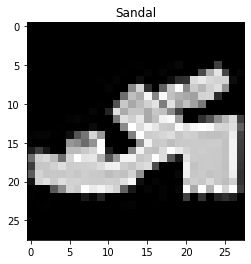

In [75]:
plt.imshow(test_imgs[0].squeeze(),cmap="gray")
plt.title(class_names[test_labels[0]]);

In [79]:
import numpy as np
pred_probs=get_preds(model=model_2,data=test_imgs,device=device)
np.argmax(np.array(pred_probs[0]))

5

In [80]:
test_labels[0]

5

In [81]:
pred_labels=pred_probs.argmax(dim=1)
pred_labels

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [83]:
list(pred_labels)==test_labels

True

In [84]:
test_labels

[5, 1, 7, 4, 3, 0, 4, 7, 1]

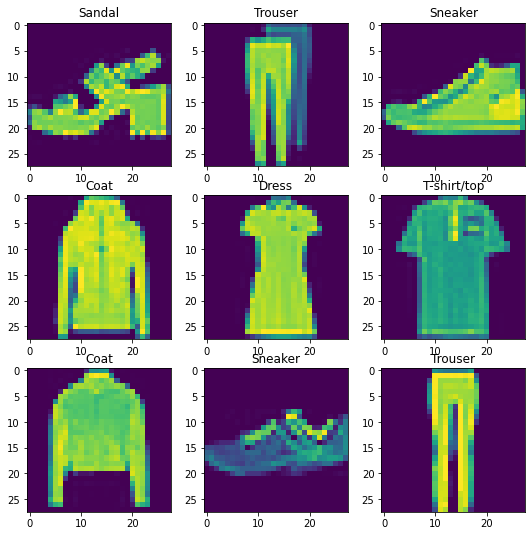

In [91]:
#plot predictions
plt.figure(figsize=(9,9))
nrows=3
ncols=3
for i,sample in enumerate(test_imgs):
  plt.subplot(nrows,ncols,i+1)
  plt.imshow(test_imgs[i].squeeze())
  plt.title(class_names[pred_labels[i]])